# POSTTEST 7 Kecerdasan Buatan
## NIM : 2209106012
## NAMA : ALDI SOLIHIN
## KELAS : A1 2022

# Import Dataset Gambar
Pertama, kita harus mengimport datasets terlebih dahulu. Dataset yang saya gunakan adalah https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set. Untuk mengimport dataset dataset kaggle ke google colab secara langsung saya menggunakan kaggle API.

In [1]:
from google.colab import files

# Upload kaggle.json dari akun kaggle (kaggle.json didapatkan dari kaggle's API)
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aldisolihin12","key":"35f3040c1ac57453bc9eecfbba3b5966"}'}

In [2]:
!mv kaggle.json /content/

mv: 'kaggle.json' and '/content/kaggle.json' are the same file


In [3]:
!chmod 600 /content/kaggle.json

Perintah dibawah digunakan untuk mendownload datasets dari kaggle di directori content

In [4]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d brsdincer/vehicle-detection-image-set

 99% 118M/119M [00:06<00:00, 23.3MB/s]
100% 119M/119M [00:06<00:00, 19.6MB/s]


Perintah dibawah digunakan untuk mengekstrak file zip dataset

In [5]:
!unzip vehicle-detection-image-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/vehicles/4414.png  
  inflating: data/vehicles/4415.png  
  inflating: data/vehicles/4416.png  
  inflating: data/vehicles/4417.png  
  inflating: data/vehicles/4418.png  
  inflating: data/vehicles/4419.png  
  inflating: data/vehicles/442.png   
  inflating: data/vehicles/4420.png  
  inflating: data/vehicles/4421.png  
  inflating: data/vehicles/4422.png  
  inflating: data/vehicles/4423.png  
  inflating: data/vehicles/4424.png  
  inflating: data/vehicles/4425.png  
  inflating: data/vehicles/4426.png  
  inflating: data/vehicles/4427.png  
  inflating: data/vehicles/4428.png  
  inflating: data/vehicles/4429.png  
  inflating: data/vehicles/443.png   
  inflating: data/vehicles/4430.png  
  inflating: data/vehicles/4431.png  
  inflating: data/vehicles/4432.png  
  inflating: data/vehicles/4433.png  
  inflating: data/vehicles/4434.png  
  inflating: data/vehicles/4435.png  
  inflating: data/vehicles/4436.png  

# Data Preparation

Pada bagian ini kita menggunakan split-folders untuk memisahkan dataset menjadi train, val, dan test

In [6]:
!pip install split-folders

In [7]:
import splitfolders

Pada bagian dibawah ini kita mengambil source dataset kita yaitu folder "data", yang kemudian akan kita buat folder baru yaitu "dataset_final", seed sebagai (random seed) yang digunakan untuk mengontrol proses pemilihan data dengan cara yang konsisten. Dengan rasio :

*   80% data akan menjadi bagian dari subset pelatihan.
*   10% data akan menjadi bagian dari subset validasi.
*   10% data akan menjadi bagian dari subset pengujian.




In [8]:
splitfolders.ratio("data", output="dataset_final", seed=1337, ratio=(.8, .1, .1))

Copying files: 17760 files [00:02, 6344.38 files/s]


## Menggunakan ImageDataGenerator Untuk Melakukan Augmentasi Pada Data

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Pada bagian dibawah ini, kita melakukan konfigurasi jenis augmentasi yang akan digunakan

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    brightness_range=[0.9,1.1],
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1/255
)

 Train dan Val generator ini akan digunakan untuk menghasilkan batch data validasi secara otomatis, target size merupakan target ukuran gambar yang diinginkan. Dan batch size merupakan jumlah gambar yang dimuat dalam satu batch

In [11]:
train_generator = train_datagen.flow_from_directory(
    '/content/dataset_final/train',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset_final/val',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

Found 14207 images belonging to 2 classes.
Found 1775 images belonging to 2 classes.


#  Membuat Arsitektur CNN

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [13]:
model = Sequential([
    # 1. Feature extraction layer
    Conv2D(128, (3,3), activation='relu', input_shape=(64,64,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # 2. Fully connected layer
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
es = callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

`callbacks.EarlyStopping` : Perintah callbacks digunakan untuk menerapkan melakukan pemberhentian epochs selama pelatihan model.

`monitor = 'val_accuracy'` : Perintah ini mengatur parameter yang dimonitor selama pelatihan, dalam hal ini, akurasi validasi (validation accuracy). Pelatihan akan berhenti jika akurasi validasi tidak meningkat.

`patience = 5`: Adalah jumlah epoch yang harus dilewati, jika tidak ada peningkatan dalam metrik yang dimonitor sebelum pelatihan dihentikan. Dalam hal ini, pelatihan akan berhenti setelah 5 epoch tanpa peningkatan akurasi validasi.

`verbose = 1` : Verbose mengatur tingkat verbosity selama pelatihan. Jika diatur sebagai 1, akan mencetak pesan saat train dihentikan.

`restore_best_weights = True` : Jika diatur sebagai `True`, bagian ini akan mengembalikan weights model ke bobot terbaik yang ditemukan selama pelatihan ketika callbacks terjadi. Ini membantu untuk mempertahankan model dengan kinerja terbaik.

In [15]:
history = model.fit(train_generator, epochs=50, validation_data=val_generator, verbose=1, callbacks=[es])

Epoch 1/50
444/444 [==============================] - 52s 83ms/step - loss: 0.2540 - accuracy: 0.8898 - val_loss: 0.1106 - val_accuracy: 0.9617
Epoch 2/50
444/444 [==============================] - 36s 81ms/step - loss: 0.1308 - accuracy: 0.9526 - val_loss: 0.0643 - val_accuracy: 0.9814
Epoch 3/50
444/444 [==============================] - 36s 82ms/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 0.1432 - val_accuracy: 0.9431
Epoch 4/50
444/444 [==============================] - 36s 81ms/step - loss: 0.0753 - accuracy: 0.9733 - val_loss: 0.0470 - val_accuracy: 0.9870
Epoch 5/50
444/444 [==============================] - 37s 83ms/step - loss: 0.0585 - accuracy: 0.9797 - val_loss: 0.0332 - val_accuracy: 0.9870
Epoch 6/50
444/444 [==============================] - 35s 79ms/step - loss: 0.0520 - accuracy: 0.9826 - val_loss: 0.0296 - val_accuracy: 0.9893
Epoch 7/50
444/444 [==============================] - 36s 82ms/step - loss: 0.0509 - accuracy: 0.9821 - val_loss: 0.0383 - val_accuracy:

In [16]:
test_datagen = ImageDataGenerator(
    rescale=1/255.0
)

test_generator = test_datagen.flow_from_directory(
    '/content/dataset_final/test',
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical'
)

Found 1778 images belonging to 2 classes.


# Evaluasi Model

In [17]:
model.evaluate(test_generator)

56/56 [==============================] - 1s 22ms/step - loss: 0.0200 - accuracy: 0.9944


[0.020047705620527267, 0.9943757057189941]

# Grafik
## 1.Model Accuracy

In [19]:
import matplotlib.pyplot as plt

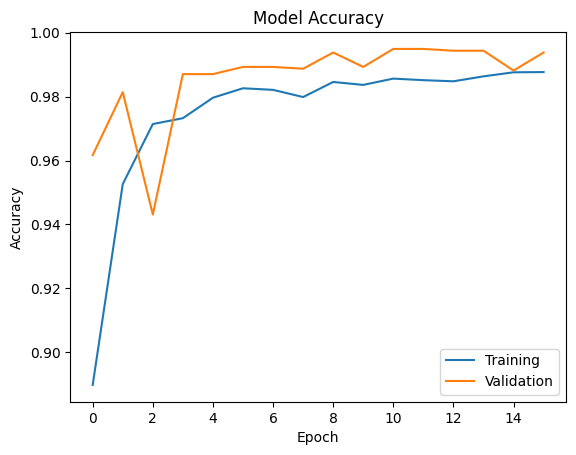

In [20]:
plt.title("Model Accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.show()

Pada grafik akurasi diatas garis berwarna biru (Training) mewakili bagaimana akurasi model berkembang seiring dengan meningkatnya jumlah epoch. Semakin tinggi garis tersebut, semakin baik kinerja model pada data pelatihan.

Garis berwarna oranye (Validation) menggambarkan akurasi model pada set data validasi. Garis ini mencerminkan sejauh mana model umumnya mampu melakukan generalisasi pada data yang belum pernah dilihat sebelumnya. Jika garis ini mengikuti atau mendekati garis akurasi pelatihan artinya hasil validasi memiliki indikasi yang baik.

## 2. Model Loss

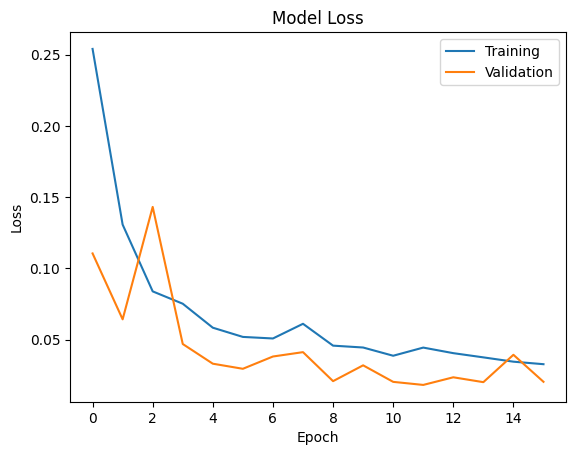

In [21]:
plt.title("Model Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.show()

Pada grafik model loss diatas garis berwarna biru (Training) menggambarkan loss model pada set data pelatihan. Garis ini mewakili bagaimana loss model berkembang seiring dengan meningkatnya jumlah epoch. Semakin rendah garis tersebut, semakin baik kinerja model pada data pelatihan.

Garis berwarna oranye (Validation) menggambarkan loss model pada set data validasi. Garis ini mencerminkan sejauh mana model umumnya mampu melakukan generalisasi pada data yang belum pernah dilihat sebelumnya. Jika garis ini mengikuti garis loss pelatihan, itu adalah indikasi baik, tetapi jika garis ini mulai meningkat, itu bisa menjadi tanda overfitting.

# Bonus : Pengetesan Model

Perintah dibawah digunakan untuk mengetahui kelas yang ada beserta indexnya

In [ ]:
train_generator.class_indices

{'non-vehicles': 0, 'vehicles': 1}

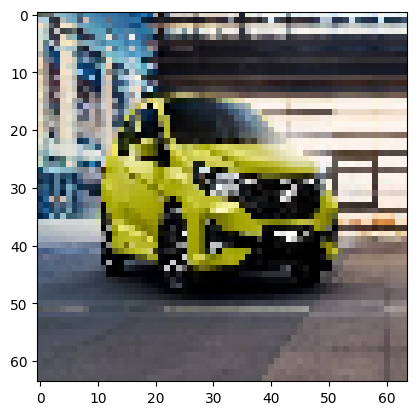

1/1 [==============================] - 0s 285ms/step
classes [[0. 1.]]
Vehicles


In [22]:
import numpy as np
import tensorflow.keras.utils as image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#ganti dengan path gambar yang diupload
path = '/content/honda-brio-18235.png'

img = image.load_img(path, target_size=(64,64))
plt.imshow(img)
plt.show()
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)

print('classes', classes)
if classes[0,0]:
  print('Non-vehicles')
elif classes[0,1]:
  print('Vehicles')